In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import gensim.downloader as api
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Masking, Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-06-27 19:57:07.743278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-27 19:57:07.743302: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# for a start, let's use the imdb reviews dataset
from tensorflow.keras.datasets import imdb

In [3]:
def load_data(percentage_of_sentences=None):
    # Load the data
    (sentences_train, y_train), (sentences_test, y_test) = imdb.load_data()
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
        len_train = int(percentage_of_sentences/100*len(sentences_train))
        sentences_train = sentences_train[:len_train]
        y_train = y_train[:len_train]
        
        len_test = int(percentage_of_sentences/100*len(sentences_test))
        sentences_test = sentences_test[:len_test]
        y_test = y_test[:len_test]
            
    # Load the {interger: word} representation
    word_to_id = imdb.get_word_index()
    word_to_id = {k:(v+3) for k,v in word_to_id.items()}
    for i, w in enumerate(['<PAD>', '<START>', '<UNK>', '<UNUSED>']):
        word_to_id[w] = i

    id_to_word = {v:k for k, v in word_to_id.items()}

    # Convert the list of integers to list of words (str)
    X_train = [' '.join([id_to_word[_] for _ in sentence[1:]]) for sentence in sentences_train]
    
    return X_train


### Just run this cell to load the data
data = load_data(percentage_of_sentences=10)

In [4]:
def get_X_y(sentence, length=20):
    '''
    returns a tuple containing:
    - a sentence (a string)
    - the word immediately following that sentence
    '''
    words = sentence.split()
    # return None if the sentence is too short
    if len(words) <= length:
        return None
    # pick a random part of the sentence
    first_word_idx = np.random.randint(0, len(words) - length)
    # build X (a part of the sentence) and y (the word immediately following X)
    X = words[first_word_idx : first_word_idx + length]
    y = words[first_word_idx + length]
    # return X and y
    return X, y

In [5]:
# check the output of the function
get_X_y(data[0])

(['so',
  'sad',
  'and',
  'you',
  'know',
  'what',
  'they',
  'say',
  'if',
  'you',
  'cry',
  'at',
  'a',
  'film',
  'it',
  'must',
  'have',
  'been',
  'good',
  'and'],
 'this')

In [6]:
def create_dataset(sentences, number_of_samples = 1000):
    '''
    creates a dataset (X and y) made of number_of_samples observations
    '''
    X, y = [], []
    indices = np.random.randint(0, len(sentences), size=number_of_samples)
    # call get_X_y number_of_samples times
    for idx in indices:
        ret = get_X_y(sentences[idx])
        if ret is None:
            continue
        xi, yi = ret
        X.append(xi)
        y.append(yi)
    return X, y

In [7]:
X, y = create_dataset(data)

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
len(X_train), len(X_test), len(y_train), len(y_test)

(699, 300, 699, 300)

In [10]:
# let's use a pre-trained word2vec
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [11]:
word2vec = api.load("glove-wiki-gigaword-50")

In [12]:
wv = word2vec

In [13]:
# check embedding size
wv["movie"].size

50

In [14]:
wv.most_similar("movie")

[('movies', 0.9322481155395508),
 ('film', 0.9310100078582764),
 ('films', 0.8937394618988037),
 ('comedy', 0.8902585506439209),
 ('hollywood', 0.8718216419219971),
 ('drama', 0.8341657519340515),
 ('sequel', 0.8222616314888),
 ('animated', 0.8216581344604492),
 ('remake', 0.812495768070221),
 ('show', 0.8105834126472473)]

In [15]:
wv.similar_by_vector(wv["movie"])

[('movie', 1.0),
 ('movies', 0.9322481155395508),
 ('film', 0.9310100078582764),
 ('films', 0.8937394022941589),
 ('comedy', 0.8902584910392761),
 ('hollywood', 0.8718216419219971),
 ('drama', 0.8341657519340515),
 ('sequel', 0.8222616314888),
 ('animated', 0.8216580748558044),
 ('remake', 0.812495768070221)]

In [16]:
vocab_size = len(wv.key_to_index)
vocab_size

400000

In [17]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=40)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=40)

In [18]:
# check X_train_pad and W_test_pad
type(X_train_pad)

numpy.ndarray

In [19]:
X_train_pad.shape

(699, 40, 50)

In [20]:
X_test_pad.shape

(300, 40, 50)

In [21]:
wv.vector_size

50

In [22]:
# check how many words from y_train are in wv
sum([word in wv for word in y_train]) / len(y_train)

0.9699570815450643

In [23]:
# check how many words from y_test are in wv
sum([word in wv for word in y_test]) / len(y_test)

0.9766666666666667

In [24]:
X_train_pad.shape, X_test_pad.shape, len(y_train), len(y_test)

((699, 40, 50), (300, 40, 50), 699, 300)

In [25]:
# filter X_train_pad (and X_test_pad) to keep only the observations for which y_train (and y_test) is in wv
mask_train = [word in wv for word in y_train]
X_train_pad = X_train_pad[mask_train, :, :]
y_train = [word for word in y_train if word in wv]
mask_test = [word in wv for word in y_test]
X_test_pad = X_test_pad[mask_test, :, :]
y_test = [word for word in y_test if word in wv]

In [26]:
X_train_pad.shape, X_test_pad.shape, len(y_train), len(y_test)

((678, 40, 50), (293, 40, 50), 678, 293)

In [27]:
# transform y_train and y_test into vectors
y_train_vec = np.array([wv[word] for word in y_train])
y_test_vec = np.array([wv[word] for word in y_test])

In [28]:
y_train_vec.shape, y_test_vec.shape

((678, 50), (293, 50))

In [29]:
# build a model
def init_model():
    model = Sequential()
    model.add(Masking())
    model.add(GRU(50, activation="tanh", return_sequences=True))
    model.add(GRU(32, activation="tanh", return_sequences=True))
    model.add(GRU(16, activation="tanh", return_sequences=False))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(50, activation="linear"))

    model.compile(loss='mae',
                  optimizer='rmsprop',
                  metrics=['mse'])
    
    return model

model = init_model()

2022-06-27 19:57:27.905042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-27 19:57:27.905265: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 19:57:27.905306: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (think): /proc/driver/nvidia/version does not exist
2022-06-27 19:57:27.905623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_pad,
                    y_train_vec, 
                    batch_size = 16,
                    epochs=100,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/100
30/30 [==============================] - 16s 153ms/step - loss: 0.4589 - mse: 0.4932 - val_loss: 0.4547 - val_mse: 0.4807
Epoch 2/100
30/30 [==============================] - 1s 46ms/step - loss: 0.4464 - mse: 0.4764 - val_loss: 0.4463 - val_mse: 0.4593
Epoch 3/100
30/30 [==============================] - 1s 48ms/step - loss: 0.4361 - mse: 0.4517 - val_loss: 0.4349 - val_mse: 0.4403
Epoch 4/100
30/30 [==============================] - 2s 52ms/step - loss: 0.4264 - mse: 0.4266 - val_loss: 0.4254 - val_mse: 0.4061
Epoch 5/100
30/30 [==============================] - 2s 50ms/step - loss: 0.4180 - mse: 0.3985 - val_loss: 0.4170 - val_mse: 0.3749
Epoch 6/100
30/30 [==============================] - 1s 48ms/step - loss: 0.4098 - mse: 0.3692 - val_loss: 0.4087 - val_mse: 0.3478
Epoch 7/100
30/30 [==============================] - 2s 52ms/step - loss: 0.4010 - mse: 0.3355 - val_loss: 0.4002 - val_mse: 0.3186
Epoch 8/100
30/30 [==============================] - 1s 48ms/step - loss: 

In [38]:
history_df = pd.DataFrame({
    "epoch" : history.epoch,
    "loss" : history.history["loss"],
    "val_loss" : history.history["val_loss"]
})

,epoch,loss,val_loss
0,0,0.458924,0.454705
1,1,0.446405,0.446258
2,2,0.436083,0.434868
3,3,0.426414,0.425384
4,4,0.417967,0.416996


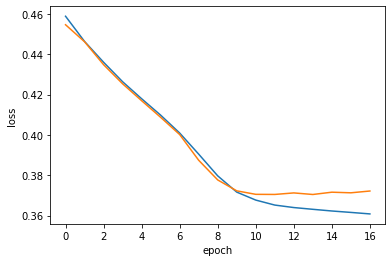

In [39]:
sns.lineplot(data=history_df, x="epoch", y="loss");
sns.lineplot(data=history_df, x="epoch", y="val_loss");

In [40]:
model.evaluate(X_test_pad, y_test_vec)

10/10 [==============================] - 0s 12ms/step - loss: 0.3643 - mse: 0.2402


[0.36432650685310364, 0.24018698930740356]

In [41]:
# let's put this into a function
def repeat_prediction(sentence, repetition=10):
    new_sentence = sentence
    X = sentence.split()
    for i in range(repetition):
        X_embed = embedding(word2vec, [X])
        X_pad = pad_sequences(X_embed, dtype='float32', padding='post', maxlen=40)
        y_pred = model.predict(X_pad)
        new_word = wv.similar_by_vector(y_pred[0], topn=1)[0][0]
        X.pop(0)
        X.append(new_word)
        new_sentence += " " + new_word
    return new_sentence

sentence = "he doesn't realize that his behavior should change and continues to act as he had before he listens to rap music sings along and plays the stereotypical part of an urban black man the real humor in this"
new_sentence = repeat_prediction(sentence)
new_sentence

1/1 [==============================] - 0s 38ms/step


"he doesn't realize that his behavior should change and continues to act as he had before he listens to rap music sings along and plays the stereotypical part of an urban black man the real humor in this but but but but but but but but but but"

In [42]:
sentence = "i like this movie and the actor"
new_sentence = repeat_prediction(sentence)
new_sentence

1/1 [==============================] - 0s 38ms/step


'i like this movie and the actor but but but but but but but but but but'

In [45]:
# inspect y_train because I suspect there are not enough training data for each word
# (if each word only appears once in y_train, it's not enough)

In [52]:
df_y = pd.DataFrame({
    "y_train" : y_train,
    "n_observation" : [1 for i in y_train]
})
df_y_sum = df_y.groupby("y_train", as_index=False).count()
df_y_sum

,y_train,n_observation
0,1983,1
1,20,1
2,2006,1
3,35,1
4,6th,1
...,...,...
377,yang,1
378,you,7
379,young,1
380,zero,1


In [55]:
df_y_sum[df_y_sum["n_observation"] != 1].sort_values(by="n_observation", ascending=False)

,y_train,n_observation
317,the,31
18,and,28
331,to,21
5,a,18
158,it,16
...,...,...
264,say,2
266,scene,2
272,series,2
278,she,2


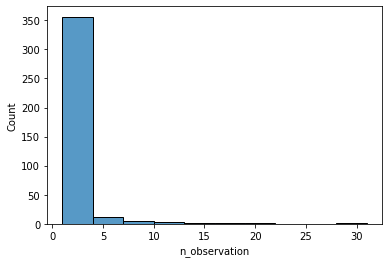

In [54]:
sns.histplot(data=df_y_sum, x="n_observation", bins=10);

In [56]:
# The issue is indeed that y_train is always different so the model cannot learn